In [ ]:
!pip install catboost
!pip install scikit-optimize
!pip install shap
#!pip install probatus
!pip install lightgbm
!pip install optuna
!pip install dython
#!pip install missingpy

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
from dython.nominal import associations
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from lightgbm import LGBMRanker
import lightgbm as lgb
import optuna
import xgboost as xgb
from catboost import cv
from catboost import Pool, CatBoostClassifier
import shap
#from probatus.feature_elimination import ShapRFECV
shap.initjs()
import pprint
import joblib
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale = 1.2)
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Number of cores
import multiprocessing
cores = multiprocessing.cpu_count() 
cores

2

In [4]:
# Colab Connection
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/1_dl_school/4_kaggle_compete/

Mounted at /content/drive
/content/drive/MyDrive/1_dl_school/4_kaggle_compete


# <center> 1. Light Data Exploration

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
# Numerical cols
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Categorical cols
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [7]:
print('train shape', train.shape)
print('test shape', test.shape)

train shape (5282, 20)
test shape (1761, 19)


In [8]:
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [9]:
# train set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
# test set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [11]:
# Changing value type
train['Sex'] = train['Sex'].astype('str')
test['Sex'] = test['Sex'].astype('str')
train['IsSeniorCitizen'] = train['IsSeniorCitizen'].astype('str')
test['IsSeniorCitizen'] = test['IsSeniorCitizen'].astype('str')

In [12]:
# Total spent is numerical col but dtype = 'object' => missing values with '' form
for i in feature_cols:
    if train[i].value_counts().sort_index().index[0] == " ":
        print(f'feature = {i}')
        print(f'index_0_train = {train[i].value_counts().sort_index().index[0]}')
        print(f'index_0_test = {test[i].value_counts().sort_index().index[0]}','\n')

feature = TotalSpent
index_0_train =  
index_0_test =   



In [13]:
def fillnan(x):
    '''Filling text NA with None value'''
    if x == ' ':
        return None
    else:
        return float(x)


train['TotalSpent'] = train['TotalSpent'].apply(fillnan)
test['TotalSpent'] = test['TotalSpent'].apply(fillnan)

# <center> 2. Exploratory Data Analysis


## 2.1 Duplicates in Data 

In [14]:
# After dropping duplicates
print('train shape', train.shape)
print('train shape without duplicates', train.drop_duplicates().shape)

train shape (5282, 20)
train shape without duplicates (5268, 20)


As we can see the train set has duplicates that we need to discard


In [15]:
train = train.drop_duplicates()

But also there may be duplicates without a target column

In [16]:
print('train shape without duplicates', train.shape)
print('train shape without duplicates (drop target col)', train.drop('Churn', axis=1).drop_duplicates().shape)

train shape without duplicates (5268, 20)
train shape without duplicates (drop target col) (5260, 19)


For some identical clients the target col has different values. Find them and drop 

In [17]:
indexes_without_noise_clients = set(train.drop('Churn', axis=1).drop_duplicates(keep=False).index)
train = train.loc[indexes_without_noise_clients,:]

## 2.1 Missing Values

In [18]:
# How many NA are in the data?
train_na_count = train.isna().sum().to_frame().rename(columns={0:'train'}).T
test_na_count = test.isna().sum().to_frame().rename(columns={0:'test'}).T
data_na_count = pd.concat([train_na_count,test_na_count])
data_na_count

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
train,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
test,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


**TotalSpent** has 9 NA in train set and 2 NA in test set

In [19]:
train[train['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [20]:
test[test['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,NaN,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


For clients who have NA, ClientPeriod == 0 and all of them aren't in Churn. Change their MonthlySpending and TotalSpent to 0.

In [21]:
train_na_indexes = train[train['TotalSpent'].isna()].index
test_na_indexes = test[test['TotalSpent'].isna()].index
train.loc[train_na_indexes,'TotalSpent'] = 0
train.loc[train_na_indexes,'MonthlySpending'] = 0
test.loc[test_na_indexes,'TotalSpent'] = 0
test.loc[test_na_indexes,'MonthlySpending'] = 0

## 2.2 Numerical Features

In [22]:
print('\t\t\t','TRAIN train','\n\n', train[num_cols].describe(),'\n\n')
print('\t\t\t','TEST train','\n\n', test[num_cols].describe())

			 TRAIN train 

        ClientPeriod  MonthlySpending   TotalSpent
count   5252.000000      5252.000000  5252.000000
mean      32.576352        65.025267  2300.361300
std       24.505058        30.226374  2269.097806
min        0.000000         0.000000     0.000000
25%        9.000000        35.737500   407.950000
50%       29.000000        70.500000  1417.325000
75%       55.000000        90.100000  3826.362500
max       72.000000       118.750000  8684.800000 


			 TEST train 

        ClientPeriod  MonthlySpending   TotalSpent
count   1761.000000      1761.000000  1761.000000
mean      32.293583        64.249830  2256.483135
std       24.593736        29.873909  2260.501794
min        0.000000         0.000000     0.000000
25%        9.000000        35.650000   405.600000
50%       29.000000        70.050000  1356.300000
75%       56.000000        89.400000  3759.050000
max       72.000000       117.350000  8496.700000


Train & Test distributions doesn't differ sighnificantly for numerical features

In [23]:
train_2 = train.drop('Churn', axis=1).copy()
train_2['train_type'] = 'train'
test_2 = test.copy()
test_2['train_type'] = 'test'
data = pd.concat([train_2,test_2], ignore_index=True)

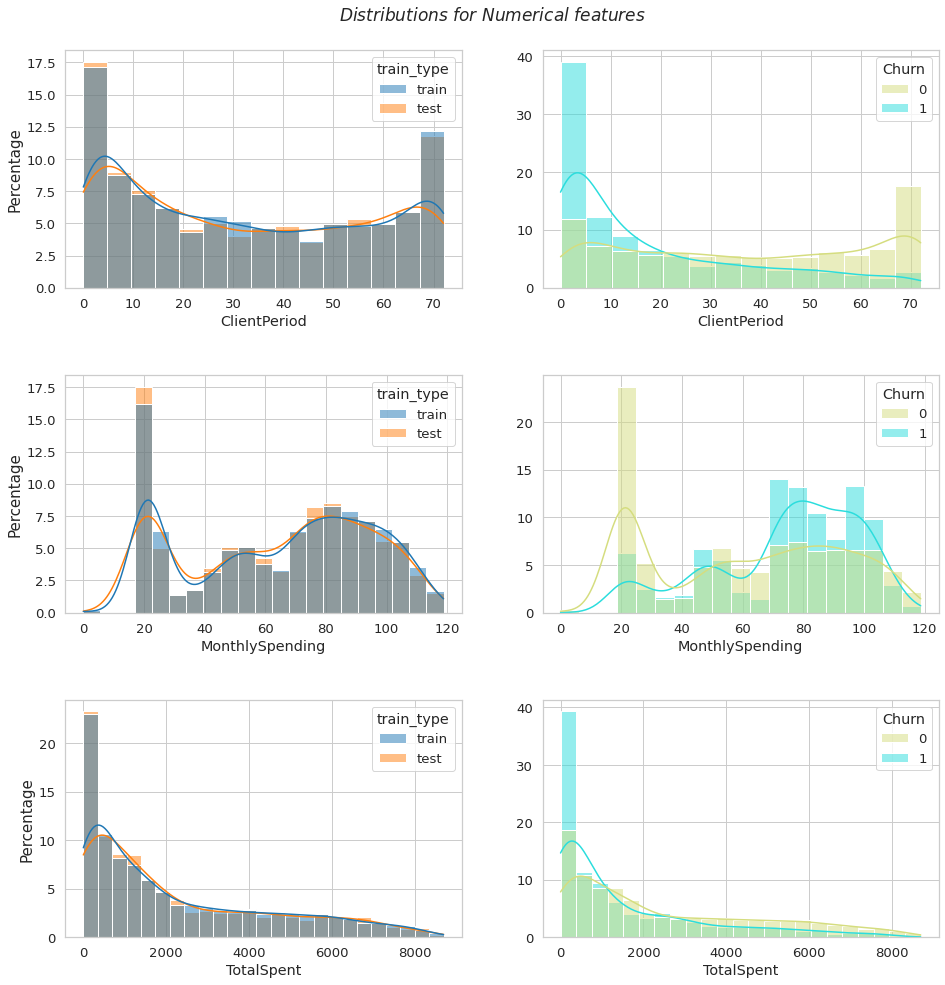

In [24]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(13, 13))
fig.tight_layout(w_pad=4, h_pad=6)
fig.suptitle(r'$Distributions\ for\ Numerical\ features$', y=1.03, fontsize=17)
for i, feature in enumerate(num_cols):
    sns.histplot(data=data, x=feature, kde=True, hue='train_type', palette='tab10', ax=axes[i,0], stat='percent', common_norm=False)
    sns.histplot(data=train, x=feature, kde=True, hue='Churn', palette='rainbow_r', ax=axes[i,1], stat='percent', common_norm=False)
    axes[i,0].set_ylabel('Percentage', fontsize=15)
    axes[i,1].set_ylabel('')

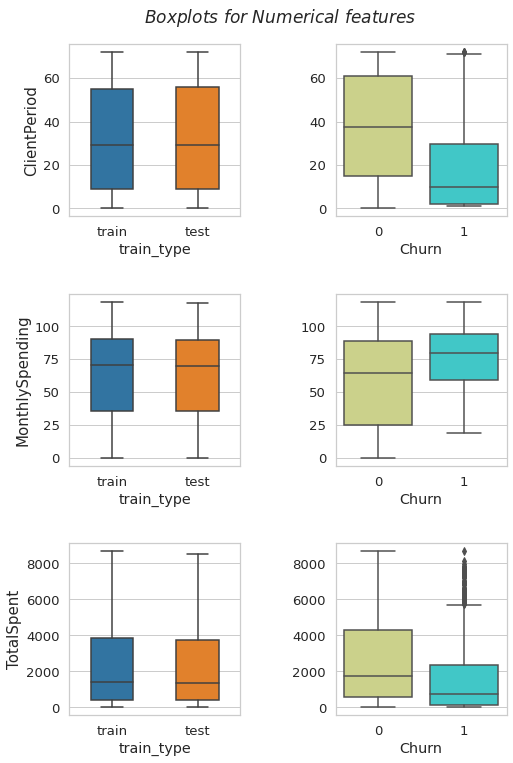

In [25]:
fig, axes = plt.subplots(len(num_cols),2, figsize = (7,10))
fig.tight_layout(w_pad = 5, h_pad = 5)
fig.suptitle(r'$Boxplots\ for\ Numerical\ features$', y=1.03, fontsize=17)
for i, feature in enumerate(num_cols):
    sns.boxplot(data=data, y=feature, x='train_type', palette='tab10', ax=axes[i,0], width=0.5)
    sns.boxplot(data=train, y=feature, x='Churn', palette='rainbow_r', ax=axes[i,1])
    axes[i,0].set_ylabel(f'{feature}', fontsize=15)
    axes[i,1].set_ylabel('')    

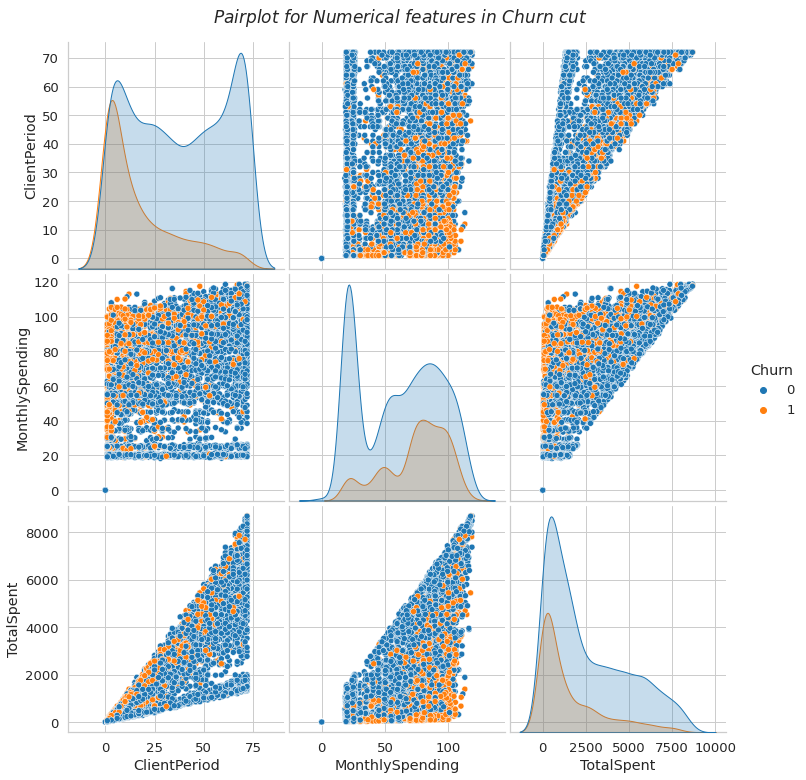

In [26]:
ax_1 = sns.pairplot(train[num_cols + ['Churn']], hue = 'Churn', palette ='tab10', height = 3.5 )
ax_1.fig.suptitle(r'$Pairplot\ for\ Numerical\ features\ in\ Churn\ cut$', y=1.03, fontsize=17)
plt.show()

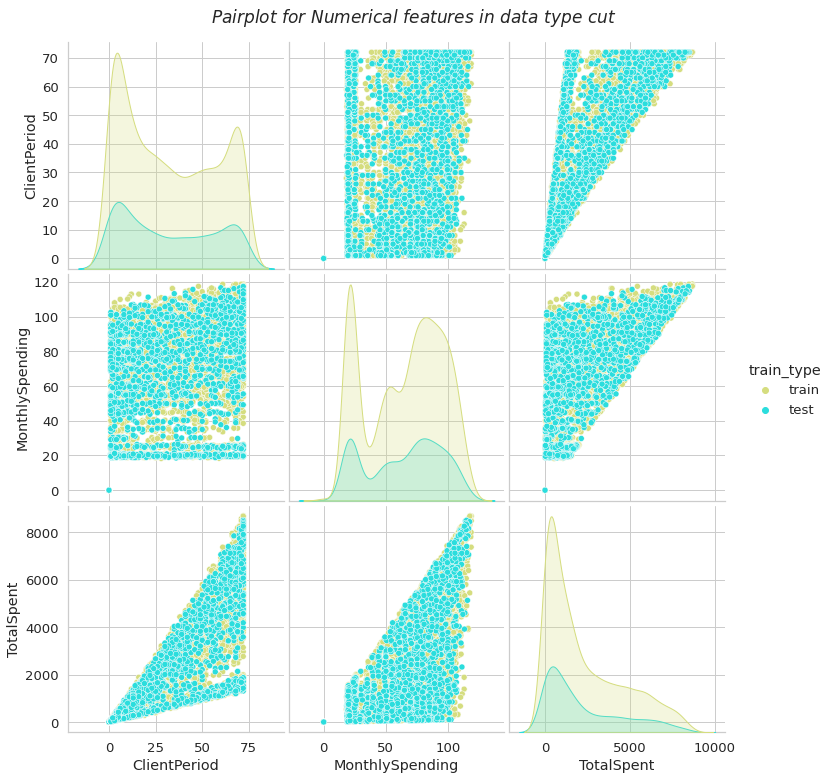

In [27]:
ax_2 = sns.pairplot(data[num_cols + ['train_type']], hue = 'train_type', palette ='rainbow_r', height = 3.5)
ax_2.fig.suptitle(r'$Pairplot\ for\ Numerical\ features\ in\ data\ type\ cut$', y=1.03, fontsize=17)
plt.show()

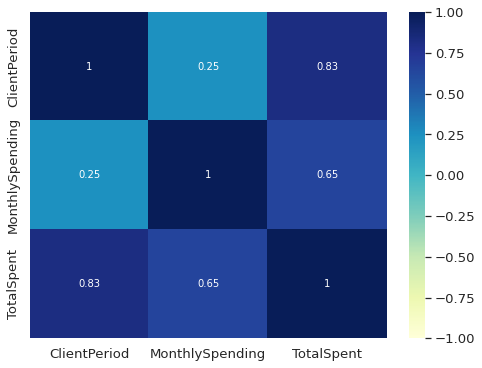

In [28]:
# Correlation btw numerical features
train_num_corr = data[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(train_num_corr, annot=True, vmin=-1, vmax=1, center=0, cmap='YlGnBu')
plt.show()

**Some conlusions:**
* There is a difference in distributions in the "Churn" cut
* There are no sighnificant outliers
* Total Spent has a heavy right tail

## 2.3 Categorical Features

In [29]:
# N unique values for cat features
cat_nunique_train = train[cat_cols].nunique().to_frame().rename(columns = {0 : 'N_Unique_train'}).T
cat_nunique_test = train[cat_cols].nunique().to_frame().rename(columns = {0 : 'N_Unique_test'}).T
cat_nunique = pd.concat([cat_nunique_train,cat_nunique_test])
cat_nunique.T

,N_Unique_train,N_Unique_test
Sex,2,2
IsSeniorCitizen,2,2
HasPartner,2,2
HasChild,2,2
HasPhoneService,2,2
HasMultiplePhoneNumbers,3,3
HasInternetService,3,3
HasOnlineSecurityService,3,3
HasOnlineBackup,3,3
HasDeviceProtection,3,3


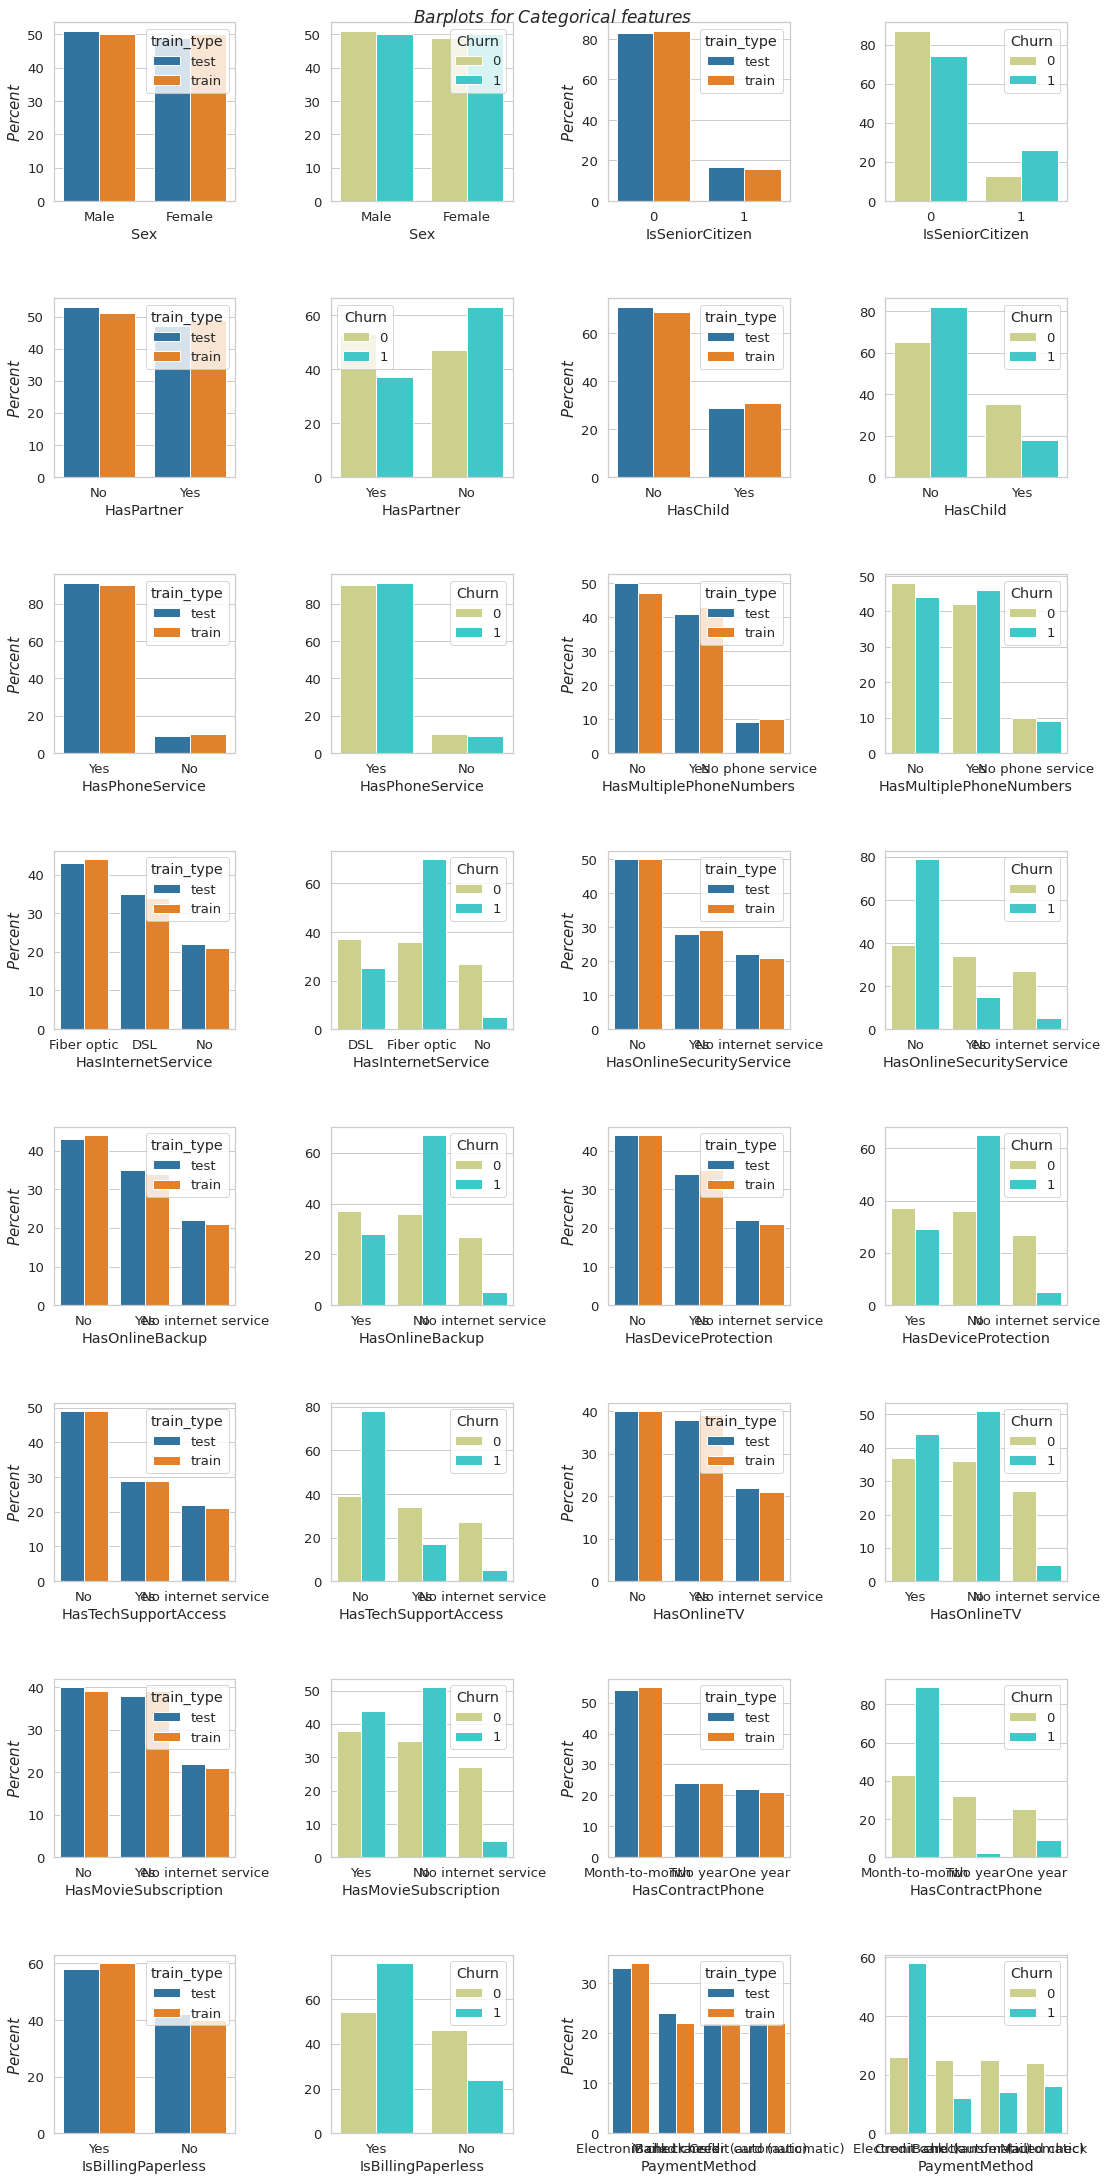

In [30]:
#barplots in percentage for categorical features
fig, axes = plt.subplots(len(cat_cols)//2,4, figsize = (15,30)) # 17 35
fig.tight_layout(w_pad = 5, h_pad = 7)
fig.suptitle(r'$Barplots\ for\ Categorical\ features$', y=1, fontsize=17)
for i, feature in enumerate(cat_cols):
    df_2 = data.groupby('train_type')[feature].value_counts(normalize=True).mul(100).round().to_frame().rename(columns = {feature:'Percent'}).reset_index()
    df_1 = train.groupby('Churn')[feature].value_counts(normalize=True).mul(100).round().to_frame().rename(columns = {feature:'Percent'}).reset_index()
    sns.barplot(data=df_2, x=feature, hue='train_type', palette='tab10', ax=axes[i//2, (i%2)*2], y='Percent')
    sns.barplot(data=df_1, x=feature, hue='Churn', palette='rainbow_r', ax=axes[i//2, (i%2)*2+1], y='Percent')
    axes[i//2, (i%2)*2].set_ylabel(r'$Percent$', fontsize=15)
    axes[i//2, (i%2)*2+1].set_ylabel('')

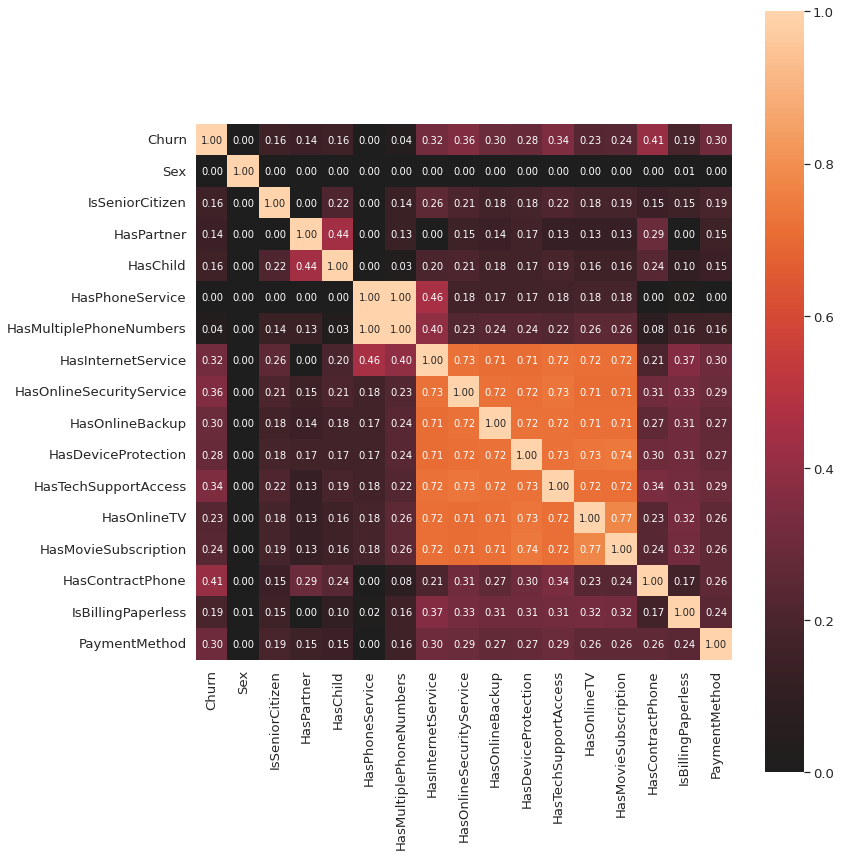

In [152]:
# Measure of association btw cat features 
cat_cols_corr = associations(train[[target_col] + cat_cols], nominal_columns=[target_col]+cat_cols, nom_nom_assoc='cramer', figsize=(12,14))

**Some conclusions**:
* Features such as Sex and HasPhoneService haven't relationship with Target and Other cat_cols, perhaps their feature_importance in Models will be almost Zero. This conclusion can confirm barplots in 'Churn' cut.
* Some cat features'r very similar, but not enough to remove one of them.
* There'r no rare categories

## 2.4 Target col

In [32]:
train.Churn.value_counts()

0    3886
1    1366
Name: Churn, dtype: int64

Classes are not balanced

## 2.5 T-SNE

In [33]:
X_train_cat_sne = train[cat_cols].copy()
X_test_cat_sne = test[cat_cols].copy()
X_train_num_sne = train[num_cols].copy()
X_test_num_sne = test[num_cols].copy()

In [34]:
X_num_sne = pd.concat([X_train_num_sne,X_test_num_sne],ignore_index = True)
X_cat_sne = pd.concat([X_train_cat_sne,X_test_cat_sne],ignore_index = True)
X_num_sne = StandardScaler().fit_transform(X_num_sne)
X_num_sne = pd.DataFrame(data=X_num_sne, columns=num_cols )
X_cat_sne = pd.get_dummies(X_cat_sne,drop_first = True)
X_sne = pd.concat([X_num_sne, X_cat_sne], axis = 1)

In [35]:
label = train['Churn'].map({0:'Churn = 0', 1:'Churn = 1'}).values.tolist() + ['test']*test.shape[0]

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


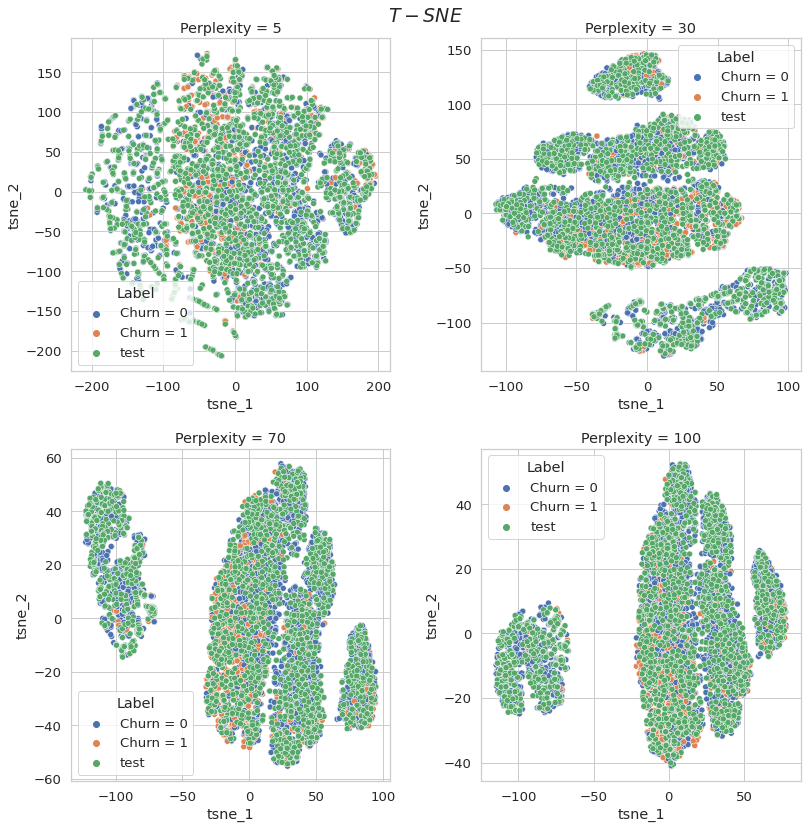

In [151]:
fig, axes = plt.subplots(2, 2, figsize=(11,11))
fig.tight_layout(w_pad = 5, h_pad = 5)
fig.suptitle(r'$T-SNE$', y=1.02, fontsize=19)
perplexity_values = [5, 30, 70, 100] 
for i, perplx in enumerate(perplexity_values):
    tsne = TSNE(n_components = 2, perplexity=perplx, n_iter=3000)
    tsne_result = tsne.fit_transform(X_sne)
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'Label': label})
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='Label', palette = 'deep', data=tsne_result_df, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Perplexity = {perplx}')

# <center> 3. Modelling

In [37]:
def feature_imp(estimator, X, type=''):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X)
    print('\n')
    shap.summary_plot(shap_values, X)

In [80]:
def submission(file, predicts):
    '''
    Submission
    '''
    preds = pd.trainFrame({'Id' : np.arange(0,len(predicts)),
                          'Churn' : predicts})
    preds.to_csv(f'{file}.csv', index = False)

## 3.1 Logistic Regression

In [38]:
# Class for choosing Scaler (numerical features)

class ChooseScaler(object):
    
    def __init__(self):
        self.std_scl = StandardScaler()
        self.rob_scl = RobustScaler()
        self.mnx_scl = MinMaxScaler()
    
    def fit(self, X,sclr):
        '''
        Fit transformer for numerical features
        :param X: Train set
        :param sclr: Scaler type
        '''
        self.sclr = sclr
        if self.sclr == 'StandardScaler':
            self.std_scl.fit(X)
            return self
        elif self.sclr == 'MinMaxScaler':
            self.mnx_scl.fit(X)
            return self
        else: 
            self.rob_scl.fit(X)
        return self

    def transform(self,X):
        '''
        Transformer
        :param X: Set for transforming
        '''
        if self.sclr == 'StandardScaler':
            return self.std_scl.transform(X)
        elif self.sclr == 'MinMaxScaler':
            return self.mnx_scl.transform
        else:
            return self.rob_scl.transform(X)

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [39]:
# Class for choosing Encoder (categorical features)

class ChooseEncoder(object):

    def __init__(self):
        self.ohe_enc = OneHotEncoder(handle_unknown = 'ignore')
        self.lbl_encdrs = {}
    
    def fit(self, X, encd):
        '''
        Fit transformer for categorical features
        :param X: Traing set
        :param sclr: Transformer type
        '''        
        self.encd = encd
        if self.encd == 'LabelEncoder':
            for i in X.columns:
                self.lbl_encdrs[i] = LabelEncoder().fit(X[i])
            return self
        else: 
            self.ohe_enc.fit(X)
            return self
        
    def transform(self,X):
        '''
        Transformation
        :param X: Set for transforming
        '''        
        if self.encd == 'LabelEncoder':
            df = X.copy()
            for i in X.columns:
                df[i] = self.lbl_encdrs[i].transform(df[i])
            return df
        else:
            return self.ohe_enc.transform(X)

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [40]:
def lr_model(X,y):
    '''
    Model fitting with hyperparameters selection: Logistic Regression "C" coef, Scaler, Encoder
    :param X: X_train
    :param y: y_train
    :return: List of Trained model, Trained Feature Transformer, 
             Best cv score, best params & cv scores.
    '''

    LR = LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 20)
    model = Pipeline(steps = [
                # Feature Preparation
                ('feature_preparation', FeatureUnion(transformer_list = [
                        # Numerical Features
                        ('numerical_values', Pipeline(steps = [
                            ('selecting', FunctionTransformer(lambda train: train.loc[:, num_cols])),
                            ('scaling', ChooseScaler())
                                ])),
                        # Categorical Features
                        ('categorical_values', Pipeline(steps = [
                            ('selecting', FunctionTransformer(lambda train: train.loc[:, cat_cols])),
                            ('encoding', ChooseEncoder())
                                ]))
                    ])),
                # Model Training
                ('model_fit', LR)
             ]
        )
    params_grid = {'model_fit__C' : np.logspace(-3,3,10),
                   'feature_preparation__numerical_values__scaling__sclr' : ['StandardScaler','RobustScaler','MinMaxScaler'],
                   'feature_preparation__categorical_values__encoding__encd' : ['OneHotEncoder','LabelEncoder']
                   }
    cv_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
    optimizer = GridSearchCV(model, params_grid, scoring = 'roc_auc', cv = cv_skf, n_jobs = -1, refit=True)
    optimizer.fit(X,y)
    best_estimator = optimizer.best_estimator_['model_fit']
    best_transformer = optimizer.best_estimator_['feature_preparation']
    best_score = optimizer.best_score_
    best_params = optimizer.best_params_
    cv_results = optimizer.cv_results_
    return [best_estimator, best_transformer, best_score, best_params,cv_results]

In [41]:
def predict(estimator, transformer, X_test):
    '''
    Test set prediction
    :param estimator: Trained model
    :param transformer: Trained feature transformer
    :param X_test: Test Set
    :return: Churn probability
    '''
    X_test = transformer.transform(X_test)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    return y_predict_proba

In [ ]:
# LR fitting
lr_model = lr_model(train[feature_cols],train[target_col].values)

In [44]:
# Best params
lr_model[3]

{'feature_preparation__categorical_values__encoding__encd': 'OneHotEncoder',
 'feature_preparation__numerical_values__scaling__sclr': 'StandardScaler',
 'model_fit__C': 1000.0}

In [45]:
# Best cv scire
np.round(lr_model[2],4)

0.8439

In [ ]:
preds_lr= predict(lr_model[0], lr_model[1], test)

In [47]:
# submission('subm_1_lr', preds_lr)

## 3.2 LightGBM

In [48]:
X_train_lgb = train.drop('Churn',axis = 1)
y_train_lgb = train['Churn'].values
X_test_lgb = test
for cat_col in cat_cols:
    X_train_lgb[cat_col] = X_train_lgb[cat_col].astype('category')
    X_test_lgb[cat_col] = X_test_lgb[cat_col].astype('category')

In [49]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
cat_feats = X_train_lgb.columns[3:].tolist()

In [50]:
dtrain_lgb = lgb.Dataset(X_train_lgb, label=y_train_lgb, categorical_feature=cat_feats, free_raw_data=False)
dtest_lgb = lgb.Dataset(X_test_lgb, categorical_feature=cat_feats, free_raw_data=False)

In [ ]:
best_score = 10
training_rounds = 1000
def objective(trial):
    param = {
        "objective": "binary",
        'is_unbalance': 'True',
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 500)
        }

    lgbcv = lgb.cv(param,
                    dtrain_lgb,
                    categorical_feature=cat_feats,
                    folds=skf,
                    early_stopping_rounds=100,                   
                    num_boost_round=1000,    
                    verbose_eval=100
                 )
     
    cv_score = lgbcv['auc-mean'][-1]  #- lgbcv['auc-stdv'][-1]
    if cv_score < best_score:
        training_rounds = len(list(lgbcv.values())[0])
    return cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

In [52]:
optuna.visualization.plot_optimization_history(study)

In [53]:
print(study.best_params)

{'learning_rate': 0.07926946401074464, 'num_leaves': 235, 'feature_fraction': 0.5948659203935899, 'bagging_fraction': 0.612260370765328, 'min_child_samples': 422}


In [54]:
best_params = {
            "objective": "binary",
            'is_unbalance': 'True',
            "metric": "auc",
            "verbosity": -1,
            "boosting_type": "gbdt",                
            "seed": 42,
            'learning_rate': 0.005} 
best_params.update(study.best_params)
best_params

{'bagging_fraction': 0.612260370765328,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.5948659203935899,
 'is_unbalance': 'True',
 'learning_rate': 0.07926946401074464,
 'metric': 'auc',
 'min_child_samples': 422,
 'num_leaves': 235,
 'objective': 'binary',
 'seed': 42,
 'verbosity': -1}

In [55]:
lgbcv = lgb.cv(best_params, dtrain_lgb, categorical_feature=cat_feats, folds=skf, early_stopping_rounds=50, num_boost_round=2000, verbose_eval=100)

[100]	cv_agg's auc: 0.847301 + 0.0132874


In [56]:
best_params['num_boost_round'] = len(lgbcv['auc-mean'])

In [57]:
model_lgb = lgb.train(best_params,
                      dtrain_lgb,
                      categorical_feature=cat_feats,
                      verbose_eval=100
                    )

Found `num_boost_round` in params. Will use it instead of argument


In [58]:
y_pred_lgb = model_lgb.predict(X_test_lgb)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


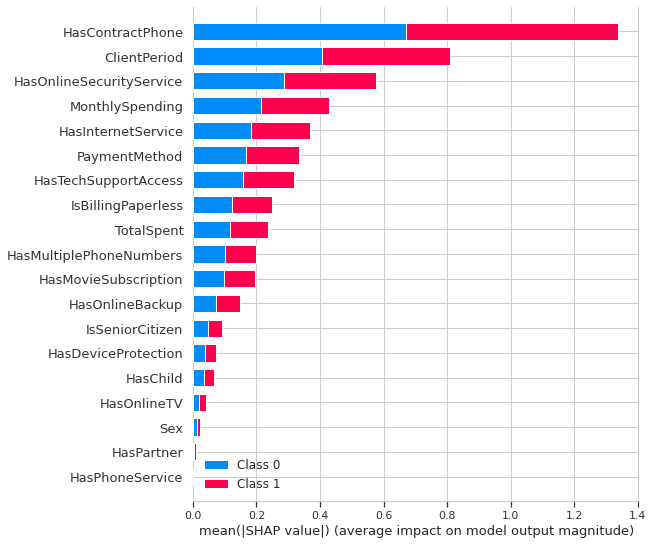

In [59]:
feature_imp(model_lgb, X_train_lgb)

In [60]:
#submission('lgb_1', y_pred_lgb)

## 3.3 XGBoost

In [61]:
def boosting_fit(clf, search_spaces, X, y):
    '''
    '''

    def status_print(optim_result):
        '''
        '''
        all_models = pd.trainFrame(opt.cv_results_)       
        best_params = pd.Series(opt.best_params_)
        print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
            len(all_models),
            np.round(opt.best_score_, 4),
            opt.best_params_
        ))

    roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    cv_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
    opt = BayesSearchCV(clf,
                        search_spaces,
                        scoring=roc_auc,
                        cv=cv_skf,
                        n_iter=100,
                        n_jobs=1,
                        return_train_score=False,
                        refit=True,
                        random_state=42)
    result = opt.fit(X, y)
    return result

In [62]:
def xgboost_fitting(X_train, y_train, X_test):
    '''
    '''
    clf_xgb = XGBClassifier(n_estimators = 50,
                          learning_rate = 0.2,
                          n_jobs = 1,                   
                          objective = 'rank:pairwise', 
                          eval_metric = 'auc',           
                          silent=1,                      
                          tree_method='auto' ,
                          #scale_pos_weight = ratio 
                        )
    
    search_spaces_xgb = {
                    'min_child_weight': (10, 500),                   
                    'max_depth': (1, 10),                          
                    'subsample': (0.4, 1.0, 'uniform'),           
                    'colsample_bytree': (0.4, 1.0, 'uniform'),     
                    }

    model_xgb = boosting_fit(clf_xgb,search_spaces_xgb,X_train,y_train)

    best_params_xgb = {'n_jobs' : 1,
                       'objective' : 'rank:pairwise',
                       'eval_metric' : 'auc',
                       'silent' : 1,
                       'tree_method' : 'auto',
                       #'scale_pos_weight' : ratio,
                       'learning_rate' : 0.05}

    for col in model_xgb.best_params_:
        best_params_xgb[col] = model_xgb.best_params_[col]

    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)

    xgbCvResult = xgb.cv(best_params_xgb, dtrain, num_boost_round=2000, nfold=4, stratified = True, early_stopping_rounds=50)

    fig, axes = plt.subplots(1,1, figsize = (10,7))
    sns.lineplot(x = range(xgbCvResult.shape[0]), y = xgbCvResult["test-auc-mean"])
    sns.lineplot(x = range(xgbCvResult.shape[0]), y = xgbCvResult["train-auc-mean"])
    axes.set_title('Valid/Train score')
    axes.set_xlabel('N_Estimators')
    axes.set_ylabel('AUC')

    best_num_round_xgb = np.argmax(xgbCvResult["test-auc-mean"])
    best_params_xgb['n_estimators'] = best_num_round_xgb*2
    best_params_xgb['learning_rate'] = best_params_xgb['learning_rate']/2
    bestXgb = XGBClassifier(**best_params_xgb).fit(X_train, y_train)
    cv_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
    best_cv_scores = cross_val_score(bestXgb, X_train, y_train, n_jobs = -1, cv = cv_skf, scoring = 'roc_auc')
    best_cv_score = best_cv_scores.mean()
    preds_xgb = bestXgb.predict_proba(X_test)[:, 1]
    preds_xgb = MinMaxScaler().fit(pd.Series(preds_xgb).to_frame()).transform(pd.Series(preds_xgb).to_frame()).flatten()

    return [preds_xgb, best_params_xgb, best_cv_scores, best_cv_score, bestXgb]

In [63]:
X_train_cat_lbl = train[cat_cols].copy()
X_train_num = train[num_cols]
X_test_cat_lbl = test[cat_cols].copy()
X_test_num = test[num_cols]
y_train = train['Churn'].values
train_cat_me_naive = train[cat_cols + ['Churn']].copy()
X_test_cat_me_naive = test[cat_cols].copy()
for cat_col in cat_cols:
    cat_col_means = train_cat_me_naive.groupby(cat_col)['Churn'].mean()
    train_cat_me_naive[cat_col] = train_cat_me_naive[cat_col].map(cat_col_means)
    X_test_cat_me_naive[cat_col] = X_test_cat_me_naive[cat_col].map(cat_col_means)
X_train_cat_me_naive = train_cat_me_naive[cat_cols]
X_train_me_naive = pd.concat([X_train_num,X_train_cat_me_naive], axis = 1)
X_test_me_naive = pd.concat([X_test_num,X_test_cat_me_naive], axis = 1)

In [64]:
X_train_me_naive = X_train_me_naive.astype(float)
X_test_me_naive = X_test_me_naive.astype(float)

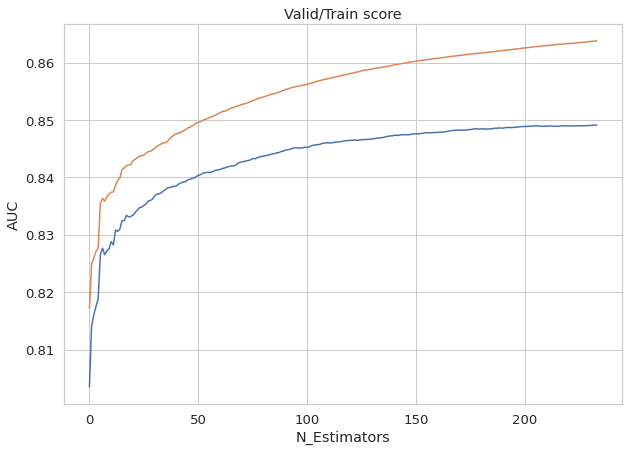

In [65]:
results_xgb_freq_1 = xgboost_fitting(X_train_me_naive, y_train, X_test_me_naive)

In [66]:
print(np.round(results_xgb_freq_1[2],5))
print(np.round(results_xgb_freq_1[3],5))

[0.86998 0.843   0.83836 0.83803]
0.84734


In [67]:
#submission('xgb_freq_2',results_xgb_freq_2[0])

## 3.4 Catboost

In [68]:
X_train_ctb = X_train_lgb
X_test_ctb = X_test_lgb
y_train_ctb = y_train_lgb
cat_features = np.arange(3,19)

In [69]:
cv_trainset = Pool(data=X_train_ctb,
                  label=y_train_ctb,
                  cat_features=cat_features)

In [ ]:
def objective_catboost(trial):    
    
    ctb_params = {        
        'learning_rate': trial.suggest_float('learning_rate', 0.005,0.05),
        'max_depth': trial.suggest_int( 'max_depth',  1,15,1),
        'rsm': trial.suggest_float('rsm', 0.3, 1),
        #'max_ctr_complexity': trial.suggest_int( 'max_ctr_complexity',  1,3,1),
        'random_state': trial.suggest_categorical('random_state',[97]),
        'loss_function': trial.suggest_categorical('loss_function',['Logloss']),
        'eval_metric': trial.suggest_categorical('eval_metric',['AUC']),
        'silent':trial.suggest_categorical('silent',[True]), 
        'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds',[50]),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights',['Balanced']),
        'boosting_type': trial.suggest_categorical('boosting_type',['Ordered'])
        }

    cv_scores = cv(params = ctb_params,
                   pool = cv_trainset,
                   fold_count=4,
                   shuffle=True,
                   stratified=True,
                   partition_random_seed=20,
                   verbose=False,
                   num_boost_round=1000
                   )
    best_value = np.max(cv_scores['test-AUC-mean'])
    return best_value

study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=50)

In [71]:
print(study.best_params)

{'learning_rate': 0.016250766026166798, 'max_depth': 3, 'rsm': 0.763675832566405, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}


In [141]:
best_params_cat = {
            "loss_function": "Logloss",
            'auto_class_weights': 'Balanced',
            "eval_metric": "AUC",
            #"silent": True,
            "boosting_type": "Ordered",                
            "random_state": 97} 
best_params_cat.update(study.best_params)

In [130]:
model = CatBoostClassifier(**best_params_cat)

In [131]:
X_train_ctb_train, X_train_ctb_valid, y_train_ctb_train, y_train_ctb_valid = train_test_split(X_train_ctb, y_train_ctb, stratify=y_train_ctb, random_state=20, test_size=0.15, shuffle=True)

In [132]:
best_params_cat

{'auto_class_weights': 'Balanced',
 'boosting_type': 'Ordered',
 'early_stopping_rounds': 50,
 'eval_metric': 'AUC',
 'learning_rate': 0.016250766026166798,
 'loss_function': 'Logloss',
 'max_depth': 3,
 'random_state': 97,
 'rsm': 0.763675832566405,
 'silent': True}

In [136]:
model.fit(X_train_ctb_train, y_train_ctb_train, cat_features=cat_features, eval_set=(X_train_ctb_valid, y_train_ctb_valid), verbose=150)

0:	test: 0.7760699	best: 0.7760699 (0)	total: 13.4ms	remaining: 13.4s
150:	test: 0.8315358	best: 0.8315358 (150)	total: 1.54s	remaining: 8.69s
300:	test: 0.8352508	best: 0.8353428 (288)	total: 2.92s	remaining: 6.79s
450:	test: 0.8368950	best: 0.8368950 (450)	total: 4.2s	remaining: 5.11s
600:	test: 0.8378655	best: 0.8378655 (600)	total: 5.63s	remaining: 3.73s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8382085931
bestIteration = 658

Shrink model to first 659 iterations.


In [142]:
best_params_cat['iterations'] = 658

In [147]:
model = CatBoostClassifier(**best_params_cat)

In [148]:
model.fit(X_train_ctb, y_train_ctb, cat_features=cat_features)

In [149]:
y_pred_ctb = model.predict(X_test_ctb)

In [150]:
#submission('catb',y_pred_ctb)